# Boundary layer problem: RBF vs. Matern

Given the problem

$$ \epsilon u'' + u' = -e^{-x} \quad\text{ for } x \in (0,1)$$

$$ u(0)=0, u(1)=1$$


where $\epsilon = 0.01$.

**Goal**: Compare the kernel collaction method solution using RBF vs. Matern 5/2. 

## Import libraries

In [7]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from importlib import reload

import KernelTools
reload(KernelTools)
from KernelTools import *

from Kernels import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

from jax.scipy.linalg import solve

### Utils

In [19]:
def solve_blp(kernel,length_scale,nugget, epsilon):
    ## Grid

    # Full points
    x_grid = np.linspace(0,1,501)
    # Interior points
    interior_x = x_grid[1:-1]
    # Boundary points
    boundary_x = np.hstack([x_grid[:1],x_grid[-1:]])

    ## Build K(phi,phi)

    eps = epsilon

    if kernel == 'Matern5_2':
        k = get_matern(2,length_scale)
    elif kernel == 'Matern11_2':
        k = get_matern(5,length_scale)    
    elif kernel == 'Matern13_2':
        k = get_matern(6,length_scale)
    elif kernel == 'RBF':
        k = get_gaussianRBF(length_scale)
    elif kernel =='RBF+Matern':
        k = get_sum_of_kernels([get_gaussianRBF(length_scale),get_matern(2,length_scale)],[0.95,0.05])

    def L_op(k,index):
        def op_result(x,y):
            inputs_arr = jnp.array([x,y])
            return eps * diff2_k(k,index)(x,y) + diff_k(k,index)(x,y)
        return op_result

    K_full = np.block(
        [
            [
                get_kernel_block_ops(k,[eval_k],[eval_k])(boundary_x,boundary_x),
                get_kernel_block_ops(k,[eval_k],[L_op])(boundary_x,interior_x)
            
            ],
            [
                get_kernel_block_ops(k,[L_op],[eval_k])(interior_x,boundary_x),
                get_kernel_block_ops(k,[L_op],[L_op])(interior_x,interior_x)
            ]
        ]
                    )
    ## Find the interpolant

    bc_vals = np.array([0,1])

    def rhs_func(x):
        return -1*np.exp(-1*x)
    rhs = np.hstack([bc_vals,rhs_func(interior_x)])

    nugget = nugget*jnp.diag(np.hstack([np.zeros(2),jnp.diag(K_full)[2:]]))
    coeffs = solve(K_full+nugget,rhs,assume_a = 'pos')

    fine_grid = np.linspace(0,1,501)
    K_interp = np.block([get_kernel_block_ops(k,[eval_k],[eval_k])(fine_grid,boundary_x),
            get_kernel_block_ops(k,[eval_k],[L_op])(fine_grid,interior_x)])
    sol_vals = K_interp@coeffs
    residual = (rhs-K_full@coeffs)

    ## True u
    def u_true(x,eps):
        coeff = np.exp(-1-x)/(-1+ np.exp(1/eps))/(-1+eps) 
        part1 = np.exp(1)-np.exp(1+1/eps)-np.exp(1+x)+np.exp(1/eps + x) -np.exp((1+x*(-1+eps))/(eps))
        part2 = -np.exp(1+ 1/eps + x - x/eps)*(-2+eps) + np.exp(1 + 1/eps + x)*(-1+eps)
        return coeff*(part1 + part2)

    # Plot the results

    plt.figure(figsize=(10,6.5))
    plt.suptitle("Solving BLP with {} kernel and length scale {}\n".format(kernel, length_scale))
    
    plt.subplot(2,2,1)
    plt.title(r'$u$ vs. $\hat u$',fontsize='small')
    plt.plot(fine_grid,u_true(fine_grid,eps),c='black', label = 'True')
    plt.plot(fine_grid,sol_vals,c='red',linestyle= 'dashed', label = 'Numerical')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(r'$P(u)$ vs.$P(\hat u)$',fontsize='small')
    plt.plot(interior_x, rhs[2:],c='black', label = 'True')
    plt.plot(interior_x, (K_full@coeffs)[2:],c='red',linestyle= 'dashed', label = 'Numerical')
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title(r'Solution residual: $|u - \hat u|$',fontsize='small')
    plt.plot(fine_grid,jnp.abs(sol_vals-u_true(fine_grid,eps)))
    plt.yscale('log')

    plt.subplot(2,2,4)
    plt.title(r'Equation Residual: $|P(u) - P(\hat u)|$',fontsize='small')
    plt.plot(interior_x,jnp.abs(residual)[2:])
    plt.yscale('log')

    plt.show()
        
        

## Results

### $\epsilon = 0.05$

RBF kernel

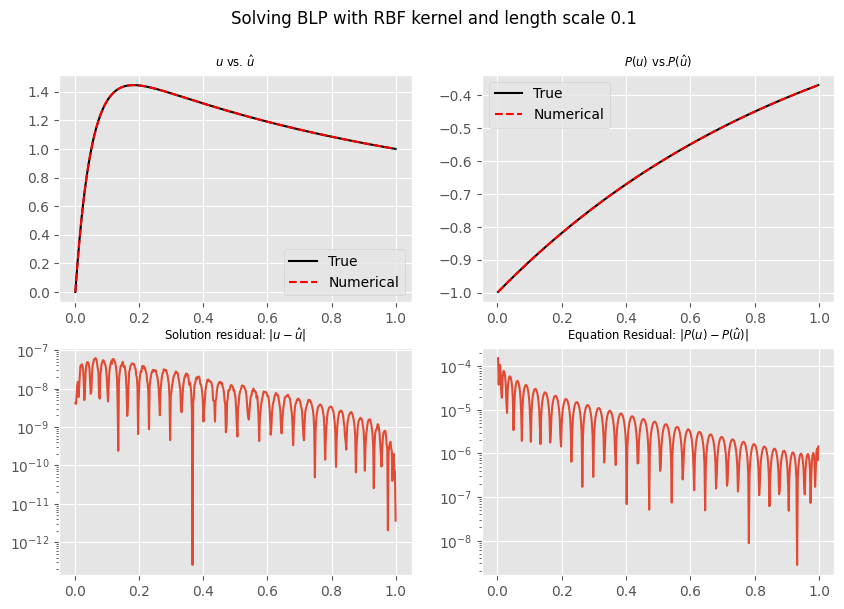

In [20]:
solve_blp("RBF",length_scale = 0.1, nugget = 1e-12, epsilon = 0.05)

Matern 5/2

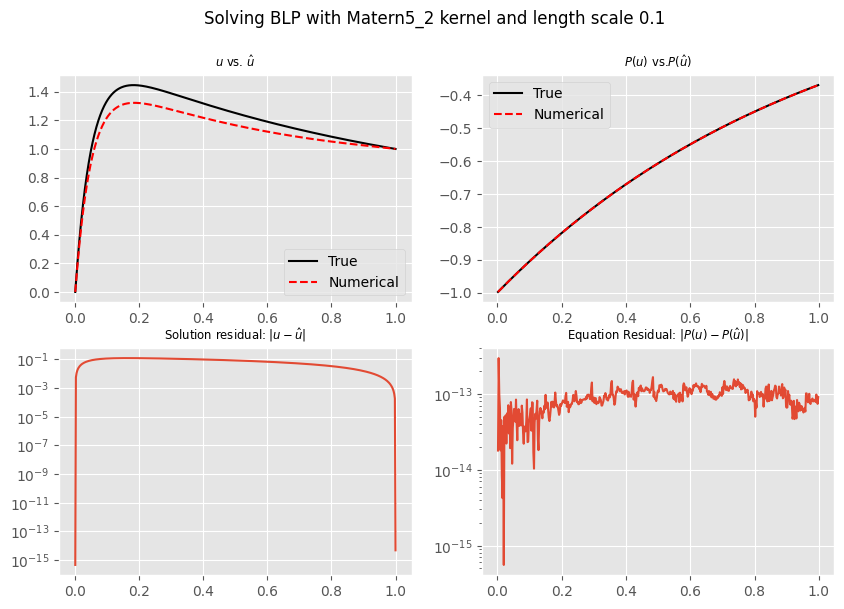

In [21]:
solve_blp("Matern5_2",length_scale = 0.1, nugget = 0, epsilon = 0.05)

Matern 11/2

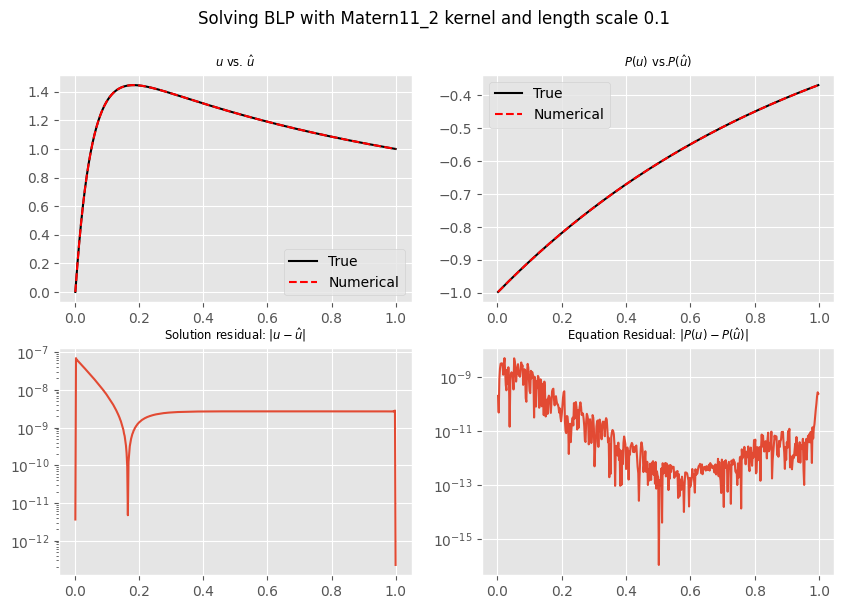

In [22]:
solve_blp("Matern11_2",length_scale = 0.1, nugget = 0, epsilon = 0.05)

### $\epsilon = 0.01$

RBF

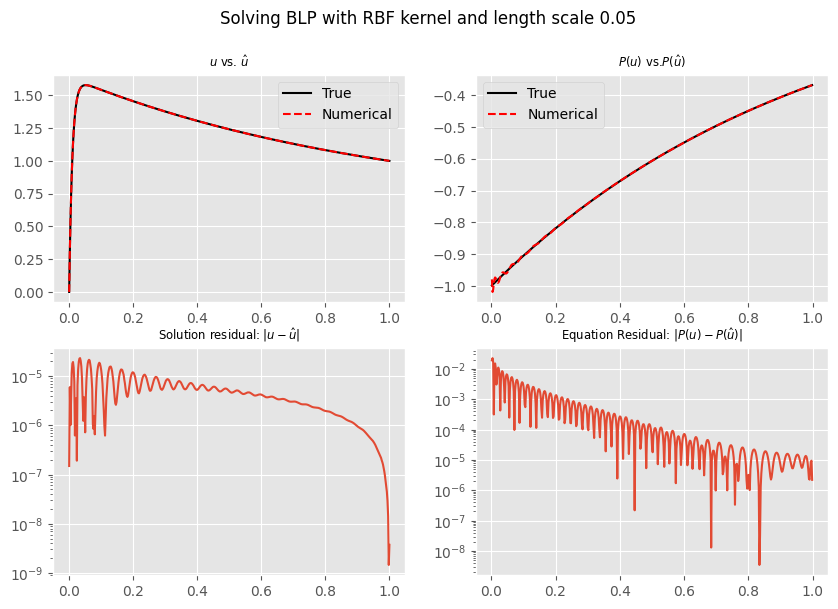

In [23]:
solve_blp("RBF",length_scale = 0.05, nugget = 1e-12, epsilon = 0.01)

Matern 5/2

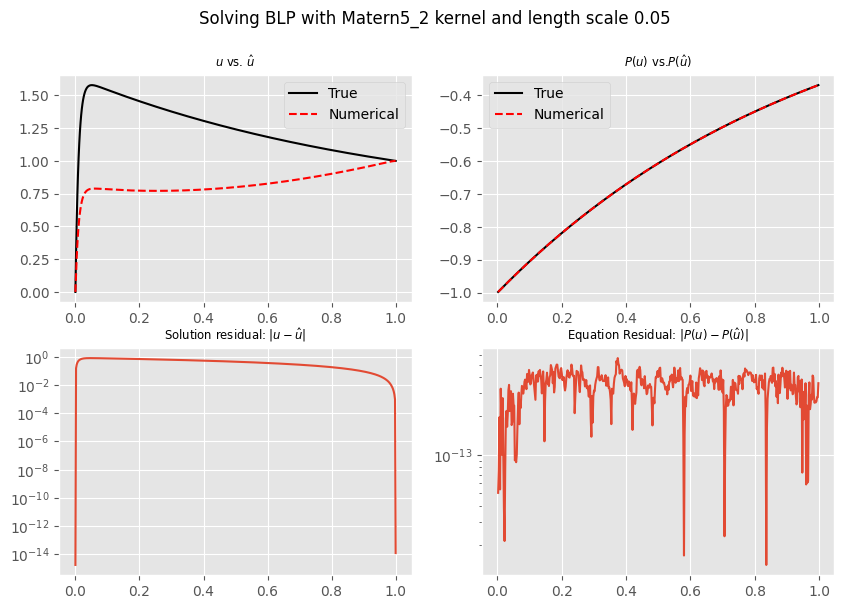

In [24]:
solve_blp("Matern5_2",length_scale = 0.05, nugget = 0, epsilon = 0.01)

Matern 11/2

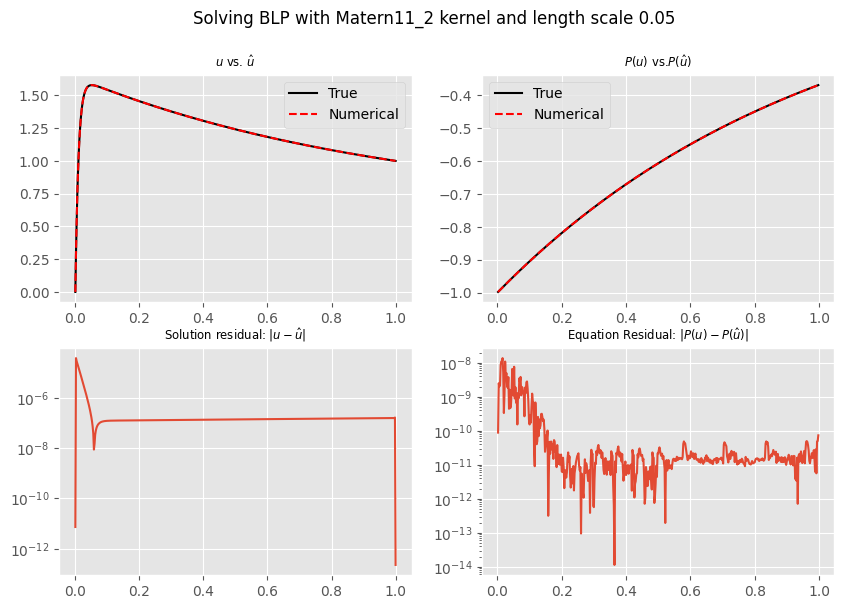

In [25]:
solve_blp("Matern11_2",length_scale = 0.05, nugget = 0, epsilon = 0.01)

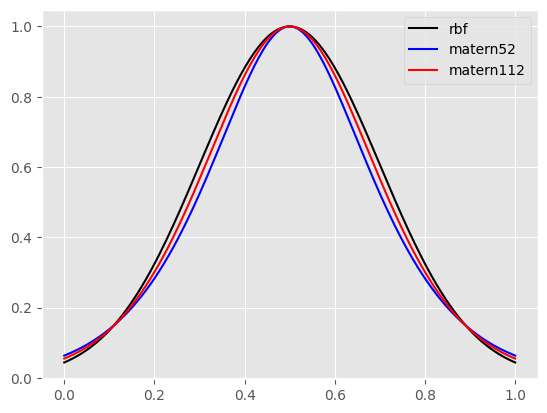

In [27]:
xtest = jnp.linspace(0,1,200)
k_rbf = vectorize_kfunc(get_gaussianRBF(.2))
k_mattern5_2 = vectorize_kfunc(get_matern(2,.2))
k_mattern11_2 = vectorize_kfunc(get_matern(5,.2))

plt.plot(xtest,k_rbf(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'black', label = 'rbf')
plt.plot(xtest,k_mattern5_2(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'blue',label = 'matern52')
plt.plot(xtest,k_mattern11_2(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'red',label = 'matern112')
plt.legend()

## Further: Iterative refinement

In [ ]:
from jax.scipy.linalg import cho_factor
from jax.scipy.linalg import cho_solve

def iterated_tikhonov(A,b,num_iter = 5,lam=1e-16):
    res_vals = []
    res_norms = []

    nugget = lam * jnp.diag(np.hstack([np.zeros(2),jnp.diag(A)[2:]]))

    res = b.copy()
    x = jnp.zeros(A.shape[1])

    C_fac = cho_factor(A + nugget)

    for i in tqdm(range(num_iter)):
        x += cho_solve(C_fac,res)
        #x += solve(A + nugget,res,assume_a = 'pos')
        res = rhs - A@x
        res_vals += [res]
        res_norms += [jnp.max(jnp.abs(res))]
    return x,res_vals,res_norms

coeffs_refined,res_vals,res_norms = iterated_tikhonov(K_full,rhs,num_iter = 500,lam = 1e-12)

In [ ]:
fine_grid = np.linspace(0,1,501)
K_interp = np.block([get_kernel_block_ops(k,[eval_k],[eval_k])(fine_grid,boundary_x),
          get_kernel_block_ops(k,[eval_k],[L_op])(fine_grid,interior_x)])
sol_vals_iterated = K_interp@coeffs_refined
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Solution")
plt.plot(fine_grid,sol_vals,c='black')
plt.subplot(1,2,2)
# plt.title("Equation Residual")
# plt.plot(interior_x,(rhs-K_full@coeffs)[2:])


final_residual = res_vals[-1][1:-1]
plt.title("Equation Residual")
plt.plot(interior_x,jnp.abs(final_residual))
plt.yscale('log')
plt.show()
plt.plot(res_norms)
plt.yscale('log')


In [ ]:
plt.plot([jnp.max(jnp.abs(x[1:-1])) for x in res_vals])
plt.yscale('log')

In [ ]:
plt.plot(interior_x,jnp.abs(res_vals[0][1:-1]))
plt.plot(interior_x,jnp.abs(res_vals[-1][1:-1]))
plt.plot(interior_x,jnp.abs(residual))
plt.yscale('log')